# Customer Lifetime Value Segment Prediction using K-Means and LightGBM

Các doanh nghiệp hiện nay đầu tư khá nhiều vào khách hàng (chi phí thu hút, quảng cáo ngoại tuyến, khuyến mãi, giảm giá, v.v.) để tạo doanh thu và sinh lãi. Đương nhiên, những hành động này khiến một số khách hàng trở nên có giá trị xét về mặt giá trị lâu dài nhưng cũng luôn tồn tại một số khách hàng sẽ làm giảm lợi nhuận của doanh nghiệp. Việc xác định những hành vi này, phân khúc khách hàng và hành động phù hợp là điều rất cần thiết với mỗi doanh nghiệp. Trong đó Giá trị vòng đời khách hàng (Customer Lifetime Value) là một trong các chỉ số rất quan trọng cần phải tính đến. CLV thường được tính cho 3, 6, 12, 24 tháng. Có khá nhiều công thức để tính CLV, tuy nhiên tôi sẽ sử dụng công thức như sau để tính CLV trong 1 năm:

**Customer Lifetime Value = Giá trị mua hàng trung bình x Số lượng đơn hàng trung bình trong 1 khoảng thời gian x Tỉ suất lợi nhuận gộp x Tuổi thọ trung bình của khách hàng**

Để dễ tính toán và giảm độ phức tạp khi thực hiện và do không đủ dữ liệu để tính toán, ta giả định tỉ suất lợi nhuận gộp là 40% (0.4) và tuổi thọ trung bình của khách hàng là 2 năm.

Ngoài, phân khúc khách hàng dựa trên CLV có thể dẫn đến sự không công bằng, do đó để đảm bảo việc phân khúc khách hàng đem lại kết quả tin cậy hơn, dự án này sẽ sử dụng kết hợp thêm mô hình RFM (Recency - Frequency - Monetary).

Các nhãn sau khi phân khúc sẽ được dùng để đào tạo cho một mô hình máy học nhằm dự đoán phân khúc khách hàng.

Link dữ liệu: https://www.kaggle.com/datasets/6e895c4ae168b052e85f73997080784443920576cdedf00b11b04fbd478f0e8d

**Mô tả về các biến có trong tập dữ liệu**
- user_id: Mã id khách hàng
- bill_id: Mã id giao dịch
- line_item_amount: Giá trị của sản phẩm
- bill_discount: Giảm giá
- transaction_date: Thời gian giao dịch được thực hiện
- description: Mô tả sản phẩm
- inventory_category: Danh mục sản phẩm
- colour: Màu sắc sản phẩm
- size: Kích cỡ sản phẩm
- zone_name: Khu vực có cửa hàng đó
- store_name: Tên cửa hàng
- year: Năm

In [1]:
# import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [2]:
# Load dữ liệu
df=pd.read_csv('data_2022.csv')
df.head()

,user_id,bill_id,line_item_amount,bill_discount,transaction_date,description,inventory_category,colour,size,zone_name,store_name,year
0,519644808,741961800,559.6,0.0,2022-04-20,MBL ITA16BLT004 Regular Casual Tan 32,MENS BELT,Tan,32,North,North_6023,2022
1,519644808,741961800,559.6,0.0,2022-04-20,MBL ITA16BLT004 Regular Casual Tan 32,MENS BELT,Tan,32,North,North_6023,2022
2,504795522,692673877,699.5,0.0,2022-01-27,MBL ITA16BLT004 Regular Casual Tan 34,MENS BELT,Tan,34,East,East_6510,2022
3,12626591,768369011,519.6,0.0,2022-10-09,MBL ITA16BLT001 Regular Casual Dark Brown 32,MENS BELT,Dark Brown,32,South,South_6017,2022
4,12626591,768369011,519.6,0.0,2022-10-09,MBL ITA16BLT001 Regular Casual Dark Brown 32,MENS BELT,Dark Brown,32,South,South_6017,2022


## Khám phá dữ liệu - EDA

In [3]:
#Thông tin các cột 
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534161 entries, 0 to 2534160
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             2534161 non-null  int64  
 1   bill_id             2534161 non-null  int64  
 2   line_item_amount    2534161 non-null  float64
 3   bill_discount       2534161 non-null  float64
 4   transaction_date    2534161 non-null  object 
 5   description         2534157 non-null  object 
 6   inventory_category  2325904 non-null  object 
 7   colour              2518848 non-null  object 
 8   size                2518848 non-null  object 
 9   zone_name           2534161 non-null  object 
 10  store_name          2534161 non-null  object 
 11  year                2534161 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 232.0+ MB


In [4]:
# Check missing values
df.isnull().sum()

user_id                    0
bill_id                    0
line_item_amount           0
bill_discount              0
transaction_date           0
description                4
inventory_category    208257
colour                 15313
size                   15313
zone_name                  0
store_name                 0
year                       0
dtype: int64

Do các giá trị null nằm chủ chủ yếu ở các cột object nên sẽ sử dụng điền giá trọ 'Unknown' cho các ô đó

In [5]:
df.describe()

,user_id,bill_id,line_item_amount,bill_discount,year
count,2.534161e+06,2.534161e+06,2.534161e+06,2.534161e+06,2534161.0
mean,4.440553e+08,7.435790e+08,1.341307e+03,1.320322e+02,2022.0
std,1.158280e+08,3.113770e+07,9.856585e+02,7.544642e+02,0.0
min,5.004900e+04,6.835057e+08,0.000000e+00,0.000000e+00,2022.0
25%,4.054491e+08,7.204882e+08,6.001548e+02,0.000000e+00,2022.0
50%,4.955304e+08,7.452438e+08,1.337060e+03,0.000000e+00,2022.0
75%,5.185644e+08,7.694484e+08,2.051461e+03,0.000000e+00,2022.0
max,5.359105e+08,8.037268e+08,1.141992e+05,5.331570e+04,2022.0


In [6]:
# Điền giá trị 'Unknown' cho dữ liệu bị thiếu
df.fillna(value='Unknown', inplace=True)

In [7]:
# Đếm số dòng bị trùng lặp
df.duplicated().sum()

558608

Trong trường hợp này, có khá nhiều dòng bị lặp, ta sẽ coi line_item_amount là đơn giá của một sản phẩm, mỗi dòng sẽ là 1 sản phẩm. Để tránh bị lặp, ta sẽ tạo thêm 1 cột để đếm số lượng dòng giống nhau và coi đó là số lượng của 1 sản phẩm trong 1 bill_id.

Số dòng còn lại sau khi trừ đi các dòng bị lặp: 2.534.161 - 558.608 = 1.975.553 dòng

In [8]:
# Gộp các dòng bị trùng lặp và điền số lượng trùng lặp vào cột quantity
df_grouped = df.groupby(['user_id','bill_id', 'line_item_amount','bill_discount',
                           'transaction_date', 'description', 'inventory_category',
                           'colour', 'size', 'zone_name', 'store_name']).size().reset_index(name='quantity')
df_grouped

,user_id,bill_id,line_item_amount,bill_discount,transaction_date,description,inventory_category,colour,size,zone_name,store_name,quantity
0,50049,734759982,5.0000,0.0,2022-03-05,CBG ITCBR00001 NA NA WHITE 12X4X16,CBG ITCBR00001 NA NA White 12x4x16``,NOT-CAPTURED,NOT-CAPTURED,South,South_6018,1
1,50049,734759982,922.5760,0.0,2022-03-05,MSH ITMSH03176 SLIM LS White M,Unknown,White,M,South,South_6018,1
2,50049,734759982,1025.1414,0.0,2022-03-05,MSH ITMSH01808 Slim LS Pale Blue M,MSH ITMSH01808 Slim LS Pale Blue M,Pale Blue,M,South,South_6018,1
3,50049,734759982,1025.1414,0.0,2022-03-05,MSH ITMSH02012 Slim LS Aqua M,MSH ITMSH02012 Slim LS Aqua M,Aqua,M,South,South_6018,1
4,50049,734759982,1025.1414,0.0,2022-03-05,MTR ITMTR00694 Kruger FF Dark Grey 34,MTR ITMTR00694 Kruger FF Dark Grey 34,Dark Grey,34,South,South_6018,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1975548,535910455,797262071,2899.0000,1800.0,2022-05-12,MTR ITMTR00608 Brooklyn FF Olive 34,MTR ITMTR00608 Brooklyn FF Olive 34,Olive,34,East,East_7443,1
1975549,535910458,797262080,1129.9261,3998.0,2022-07-31,MTR ITMTR00695 Brooklyn FF Beige 28,Unknown,Beige,28,East,East_7443,1
1975550,535910458,797262080,1129.9261,3998.0,2022-07-31,MTR ITMTR00695 Brooklyn FF Dark Grey 28,Unknown,Dark Grey,28,East,East_7443,1
1975551,535910458,797262080,1469.0737,3998.0,2022-07-31,MTR ITMTR00736 Brooklyn FF Navy 28,MTR ITMTR00736 Brooklyn FF Navy 28,NOT-CAPTURED,NOT-CAPTURED,East,East_7443,1


In [9]:
# Xóa các cột không cần thiết
data=df_grouped.drop(columns=['bill_discount', 'description', 'inventory_category', 'colour', 'size', 'zone_name', 'store_name'])
data.head()

,user_id,bill_id,line_item_amount,transaction_date,quantity
0,50049,734759982,5.0000,2022-03-05,1
1,50049,734759982,922.5760,2022-03-05,1
2,50049,734759982,1025.1414,2022-03-05,1
3,50049,734759982,1025.1414,2022-03-05,1
4,50049,734759982,1025.1414,2022-03-05,1


## Thực hiện tính toán

### 1. Tính RFM

#### 1.1. Recency

**Recency:** là khoảng thời gian giữa lần giao dịch gần nhất tới thời điểm hiện tại của khách hàng. Khoảng thời gian này càng lớn thì khách hàng càng có khả năng rời bỏ cao, đồng nghĩa với việc cửa hàng sẽ tốn thời gian vào việc chăm sóc và thuyết phục họ mua lại. Ngược lại khoảng thời gian này càng nhỏ thì khả năng tiếp cận sẽ càng cao.

In [10]:
# Xử lý cột transaction_date
data['transaction_date']=pd.to_datetime(df['transaction_date'])

In [11]:
# Tính ngày cuối cùng mua hàng của mỗi khách hàng
data_recency=data.groupby('user_id').agg(last_purchase_date=('transaction_date', 'max')).reset_index()

# Tính số ngày kể từ lần cuối khách hàng mua hàng (Mốc thời gian để tính Recency là 31/12/2022)
data_recency['recency']=(dt.datetime(2022, 12, 31)-data_recency.last_purchase_date).dt.days

data_recency.head()

,user_id,last_purchase_date,recency
0,50049,2022-10-09,83
1,50511,2022-11-10,51
2,50565,2022-12-31,0
3,53796,2022-05-23,222
4,54143,2022-08-31,122


#### 1.2. Frequency

**Frequency:** là tần suất mua hàng của khách hàng. Khách hàng mua hàng càng nhiều thường có khả năng phản hồi lại với các chiến dịch tiếp thị của cửa hàng và dễ trở thành khách hàng trung thành.

In [12]:
# Tính frequency
data_freq=data.groupby('user_id').agg(frequency=('bill_id', 'count')).reset_index()

data_freq.head()

,user_id,frequency
0,50049,10
1,50511,11
2,50565,3
3,53796,6
4,54143,6


#### 1.3. Monetary

**Monetary:** là tổng số tiền mà khách hàng đã chi tiêu bằng việc mua hàng tại cửa hàng. Mức độ chi tiêu sẽ cho biết khả năng chi tiêu của khách hàng nằm ở đâu, từ đó có những chiến lược cụ thể để chăm sóc khách hàng.

In [13]:
# Tính Monetary
data['total_amount']=data['line_item_amount']*data['quantity']
data_money=data.groupby('user_id').agg(monetary=('total_amount', 'sum')).reset_index()

data_money.head()

,user_id,monetary
0,50049,8805.0001
1,50511,16246.0021
2,50565,3198.0010
3,53796,6195.0032
4,54143,8896.0030


In [14]:
# Tổng hợp kết quả RFM
customer=pd.DataFrame(data['user_id'].unique())
customer.columns=['user_id']

# Nổi các bảng chứa kết quả RFM vào bảng customer
data_customer=pd.merge(customer, data_recency, how='left', on='user_id')
data_customer=pd.merge(data_customer, data_freq, how='left', on='user_id')
data_customer=pd.merge(data_customer, data_money, how='left', on='user_id')
data_customer.drop(columns='last_purchase_date', inplace=True)
data_customer.head()

,user_id,recency,frequency,monetary
0,50049,83,10,8805.0001
1,50511,51,11,16246.0021
2,50565,0,3,3198.0010
3,53796,222,6,6195.0032
4,54143,122,6,8896.0030


### 2. Chấm điểm RFM cho từng khách hàng

#### 2.1. Chấm điểm cho từng chỉ số RFM

Có khá nhiều cách để chấm điểm RFM cho từng khách hàng, tuy nhiên trong dự án này, ta sẽ sử dụng K-Means để phân cụm cho từng chỉ số, sau đó sẽ tính tổng điểm RFM. Một vấn đề xảy ra là với mỗi lĩnh vực khác nhau, mức độ ưu tiên của từng chỉ số là khác nhau, chẳng hạn như với ngành bán xe ô tô thì R và F không quan trọng bằng M; với một số ngành khác thì họ sẽ quan tâm đến R và F nhiều hơn. Do đó trong trường hợp này, ta sẽ thêm trọng số để tính tổng điểm RFM cho từng khách hàng nhằm tránh xảy ra sự mất cân bằng.

In [15]:
data_customer.describe()

,user_id,recency,frequency,monetary
count,3.388830e+05,338883.000000,338883.000000,3.388830e+05
mean,4.666658e+08,113.059395,5.829602,1.003027e+04
std,9.969383e+07,94.147126,8.112031,3.045359e+04
min,5.004900e+04,0.000000,1.000000,0.000000e+00
25%,4.460128e+08,31.000000,2.000000,2.599001e+03
50%,5.078375e+08,87.000000,4.000000,5.098002e+03
75%,5.218344e+08,174.000000,6.000000,9.606415e+03
max,5.359105e+08,364.000000,522.000000,8.021671e+06


Kết quả trên cho thấy F và M có sự khác thường. Dễ thấy 75% khách hàng có Frequency <=6 trong khi Frequency lớn nhất lại là 522. Tương tự với Monetary. Điều đó cho thấy các chỉ số RFM đang có phân phối lệch, việc sử dụng phân cụm trong trường hợp này sẽ làm giảm độ chính xác của các cụm, từ đó gán sai điểm số cho mỗi khách hàng.

''

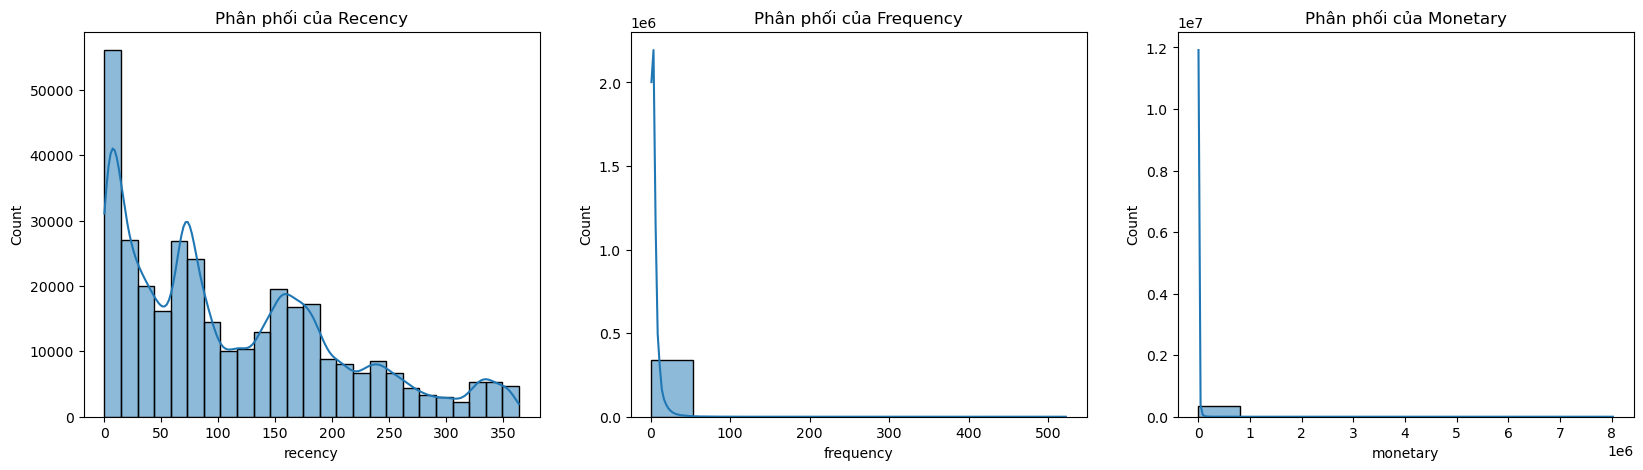

In [16]:
# Kiểm tra tính phân phối của RFM
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.histplot(data=data_customer, x='recency', bins=25, kde=True, ax=ax[0])
sns.histplot(data=data_customer, x='frequency', bins=10, kde=True, ax=ax[1])
sns.histplot(data=data_customer, x='monetary', bins=10, kde=True, ax=ax[2])
ax[0].set_title('Phân phối của Recency')
ax[1].set_title('Phân phối của Frequency')
ax[2].set_title('Phân phối của Monetary')
;

Để việc phân cụm trở nên có ý nghĩa thì các đặc điểm trong dữ liệu cần có phân phối chuẩn. Dựa vào 3 biểu đồ trên, các chỉ số đều có phân phối lệch. Để kết quả phân cụm đem lại độ chính xác cao thì việc giải quyết đưa các cột về phân phối chuẩn hoặc gần chuẩn là cần thiết. Trong trường hợp này, ta sẽ sử dụng 2 phép biến đổi là Logarit và Square root và lựa chọn cách biến đổi với độ lệch của phân phối là thấp nhất

In [17]:
# Tạo hàm để vẽ phân phối trước và sau khi biến đổi
def skew_analyze(x):
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    sns.histplot(data=data_customer, x=x, kde=True, ax=ax[0])
    sns.histplot(data=data_customer, x=np.log(data_customer[x]), kde=True, ax=ax[1])
    sns.histplot(data=data_customer, x=np.sqrt(data_customer[x]), kde=True, ax=ax[2])
    ax[0].set_title('Không biến đổi')
    ax[1].set_title('Biến đổi Logarit')
    ax[2].set_title('Biến đổi Square Root')
    plt.show()

    print(data_customer[x].skew().round(2))
    print(np.log(data_customer[x]).skew().round(2))
    print(np.sqrt(data_customer[x]).skew().round(2))

C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


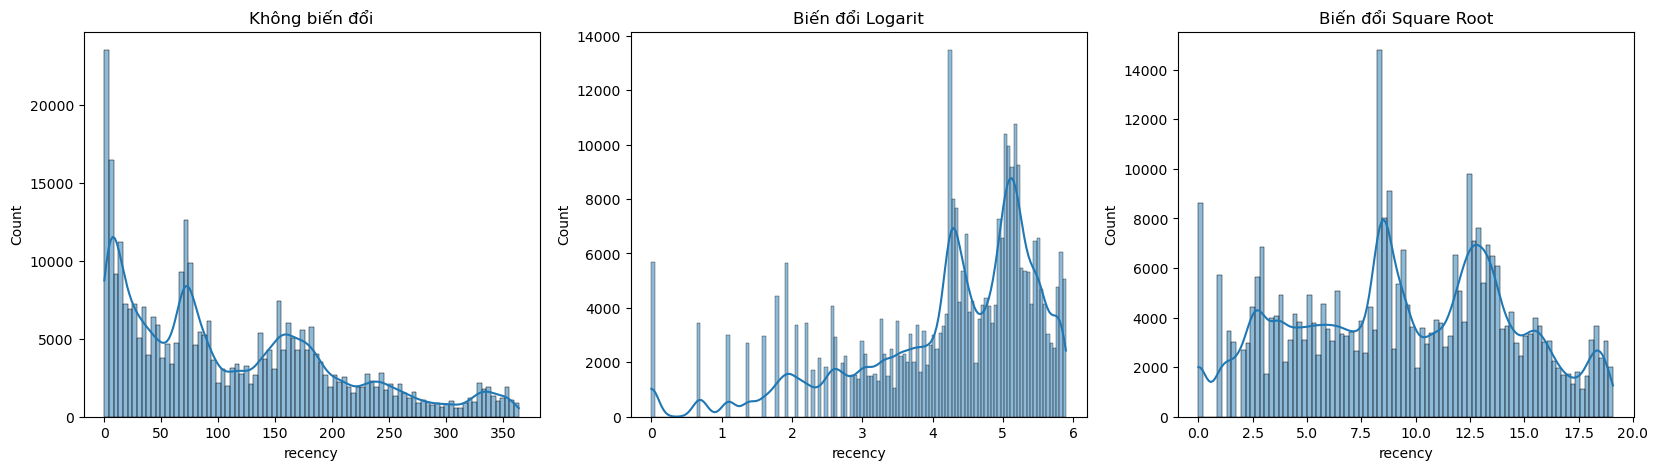

0.76
nan
-0.05


C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


In [18]:
# Thử với recency
skew_analyze('recency')

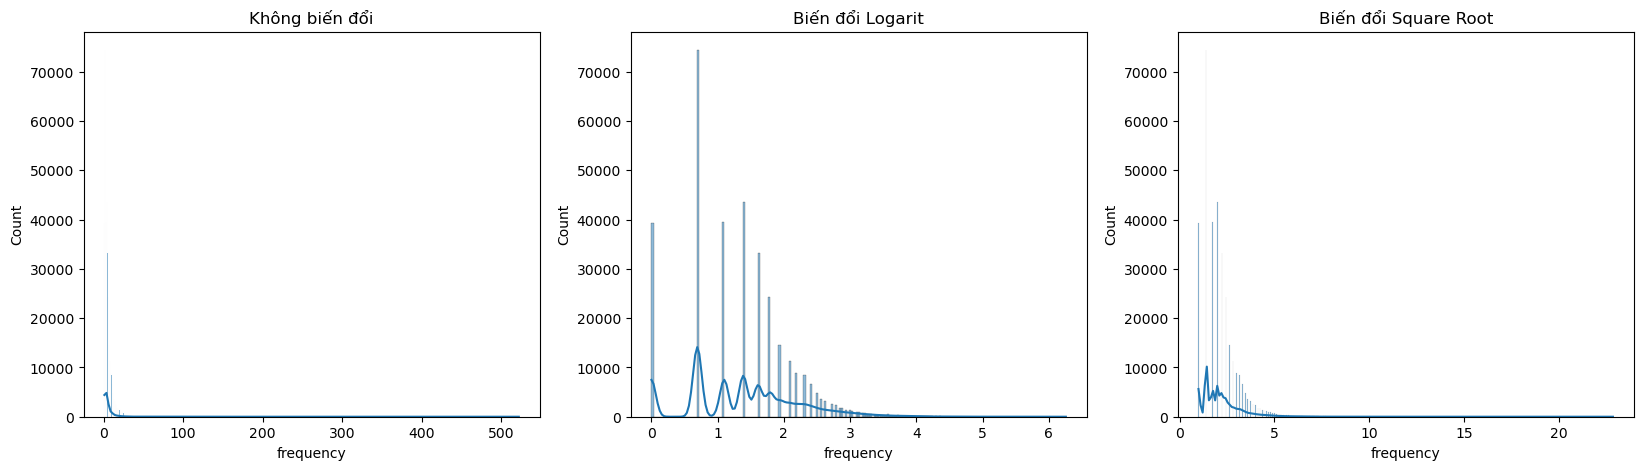

11.91
0.41
2.43


In [19]:
# Thử với frequency
skew_analyze('frequency')

C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


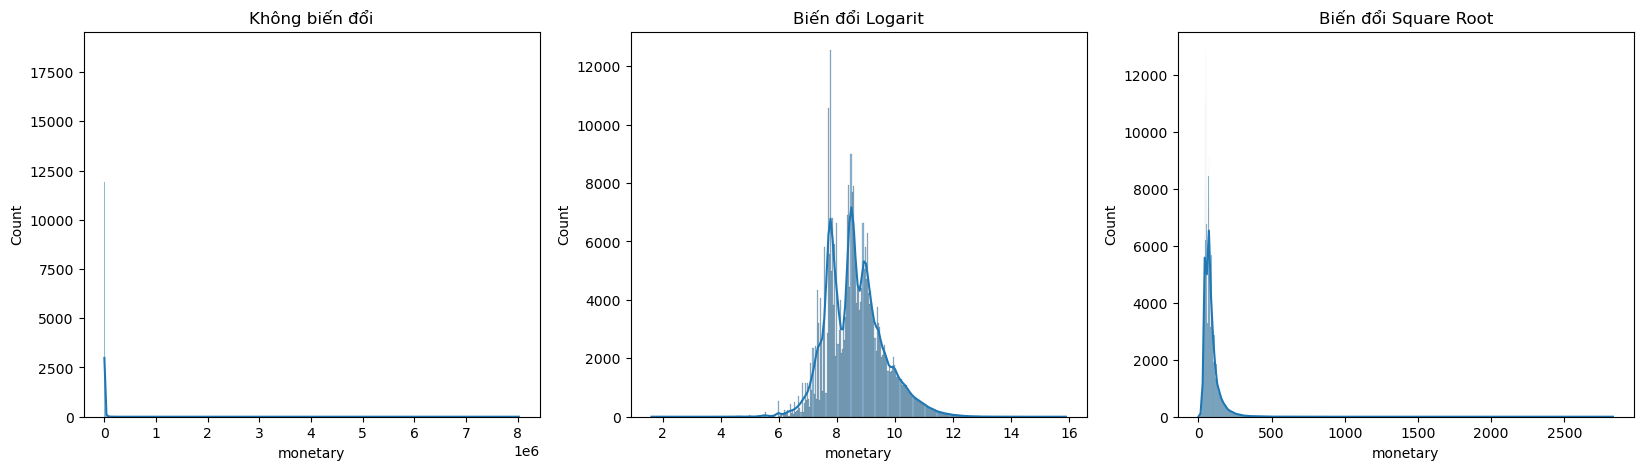

112.44
nan
4.43


C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


In [20]:
# Thử với monetary
skew_analyze('monetary')

Từ 3 kết quả trên cho thấy:
- Recency: sử dụng biến đổi Square root
- Frequency: sử dụng biến đổi Logarit
- Monetary: sử dụng biến đổi Square root

In [50]:
# Transform data
data_customer_t=pd.DataFrame()
data_customer_t['user_id']=data_customer['user_id']
data_customer_t['recency']=pd.Series(np.sqrt(data_customer['recency']))
data_customer_t['frequency']=pd.Series(np.log(data_customer['frequency']))
data_customer_t['monetary']=pd.Series(np.sqrt(data_customer['monetary']))

data_customer_t.head()

,user_id,recency,frequency,monetary
0,50049,9.110434,2.302585,93.834962
1,50511,7.141428,2.397895,127.459806
2,50565,0.000000,1.098612,56.550871
3,53796,14.899664,1.791759,78.708343
4,54143,11.045361,1.791759,94.318625


**Phân cụm (tính điểm số) cho từng chỉ số trong RFM, và tính tổng điểm RFM cho từng khách hàng**

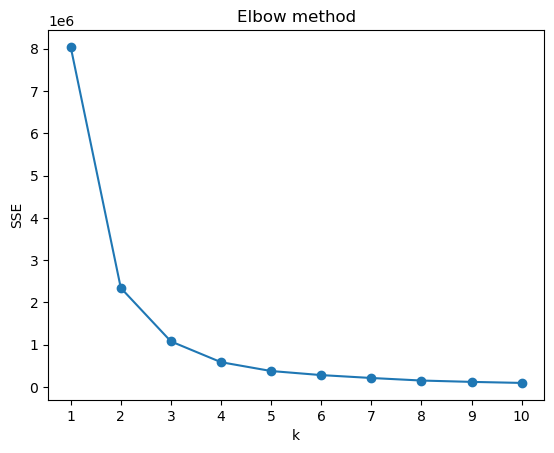

In [51]:
from sklearn.cluster import KMeans

# Tìm số cụm thích hợp bằng Elbow
sse={}
for k in range(1,11):
    kmeans=KMeans(n_clusters=k, random_state=10)
    kmeans.fit(data_customer_t[['recency']])
    sse[k]=kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), 'o-')
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(range(1,11))
plt.show()

In [52]:
# Phân cụm cho Recency
kmeans=KMeans(n_clusters=5, random_state=1) # Lựa chọn k=5
data_customer_t['recency_score']=kmeans.fit_predict(data_customer_t[['recency']])
data_customer_t.groupby('recency_score').recency.describe()

,count,mean,std,min,25%,50%,75%,max
recency_score,,,,,,,,
0,84626.0,8.858510,0.910756,7.141428,8.306624,8.717798,9.486833,10.816654
1,50121.0,16.775444,1.317693,14.798649,15.588457,16.492423,18.110770,19.078784
2,53154.0,2.015398,1.157897,0.000000,1.000000,2.449490,2.828427,3.605551
3,93195.0,12.811973,0.990444,10.862780,12.083046,12.806248,13.527749,14.764823
4,57787.0,5.388454,0.992158,3.741657,4.582576,5.385165,6.244998,7.071068


Ta đã phân cụm cho từng ID khách hàng. Nhưng mỗi cụm được chỉ định ngẫu nhiên. Chẳng hạn như cụm 2 là cụm có thời gian giao dịch gần đây là ngắn nhất, do đó điểm số cần được cao xếp cao nhất, tuy nhiên trong trường hợp này, cụm 2 (tương ứng với 3 điểm theo thang 5) lại đang thấp hơn so với cụm 4 (tương ứng với điểm 5). Do đó ta cần sắp xếp các cụm giảm dần theo giao dịch gần đây nhất. Có nghĩa là giao dịch càng gần thì sẽ càng được điểm cao.

In [53]:
# Tạo hàm để sắp xếp cho thứ tự cụm cho riêng cột recency
def order_recency(cluster_field, target_field, df, ascending):
    new_cluster_field = 'new_'+cluster_field
    df_new = df.groupby(cluster_field)[target_field].mean().reset_index()
    df_new = df_new.sort_values(by=target_field,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field,'index']], on=cluster_field)
    df_final = df_final.drop([cluster_field],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field})
    return df_final

data_customer_t=order_recency('recency_score', 'recency', data_customer_t, False)
data_customer_t.groupby('recency_score').recency.describe()

,count,mean,std,min,25%,50%,75%,max
recency_score,,,,,,,,
0,50121.0,16.775444,1.317693,14.798649,15.588457,16.492423,18.110770,19.078784
1,93195.0,12.811973,0.990444,10.862780,12.083046,12.806248,13.527749,14.764823
2,84626.0,8.858510,0.910756,7.141428,8.306624,8.717798,9.486833,10.816654
3,57787.0,5.388454,0.992158,3.741657,4.582576,5.385165,6.244998,7.071068
4,53154.0,2.015398,1.157897,0.000000,1.000000,2.449490,2.828427,3.605551


In [54]:
# Tuy nhiên để đưa các cụm theo thang điểm từ 1 đến 5, tôi sẽ cộng thêm 1 vào mỗi cụm
data_customer_t['recency_score']=data_customer_t['recency_score']+1
data_customer_t.groupby('recency_score').recency.describe()

,count,mean,std,min,25%,50%,75%,max
recency_score,,,,,,,,
1,50121.0,16.775444,1.317693,14.798649,15.588457,16.492423,18.110770,19.078784
2,93195.0,12.811973,0.990444,10.862780,12.083046,12.806248,13.527749,14.764823
3,84626.0,8.858510,0.910756,7.141428,8.306624,8.717798,9.486833,10.816654
4,57787.0,5.388454,0.992158,3.741657,4.582576,5.385165,6.244998,7.071068
5,53154.0,2.015398,1.157897,0.000000,1.000000,2.449490,2.828427,3.605551


Để điểm số giữa các chỉ số RFM được đo trên cùng 1 thang điểm, ta vẫn sẽ sử dụng k=5 để phân cụm cho cả 2 chỉ số còn lại

In [55]:
# Phân cụm cho Frequency
data_customer_t['frequency_score']=kmeans.fit_predict(data_customer_t[['frequency']])
data_customer_t.groupby('frequency_score').frequency.describe()

,count,mean,std,min,25%,50%,75%,max
frequency_score,,,,,,,,
0,39363.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,107402.0,1.897663,2.602965e-01,1.609438,1.609438,1.791759,2.079442,2.397895
2,74376.0,0.693147,1.076924e-12,0.693147,0.693147,0.693147,0.693147,0.693147
3,34650.0,2.945084,4.488963e-01,2.484907,2.639057,2.833213,3.135494,6.257668
4,83092.0,1.249644,1.436620e-01,1.098612,1.098612,1.386294,1.386294,1.386294


In [56]:
# Phân cụm cho Monetary
data_customer_t['monetary_score']=kmeans.fit_predict(data_customer_t[['monetary']])
data_customer_t.groupby('monetary_score').monetary.describe()

,count,mean,std,min,25%,50%,75%,max
monetary_score,,,,,,,,
0,149538.0,49.853915,10.606413,0.000000,43.577529,48.979598,56.905184,68.111702
1,42654.0,144.497052,21.009806,115.474023,126.059525,141.353177,159.965625,192.327868
2,1513.0,453.815649,167.506400,347.064122,371.129467,406.844002,473.465429,2832.255473
3,132753.0,86.357528,13.212520,68.119748,74.141763,85.422480,95.895777,115.453472
4,12425.0,239.956850,38.630187,192.335644,208.271504,229.743734,263.838045,347.033913


Cũng tương tự như Recency, ta phải sắp xếp lại thứ tự các cụm, tuy nhiên sẽ có sự khác biệt, nếu như recency càng nhỏ thì điểm càng lớn, với frequency và monetary sẽ ngược lại, frequency và monetary càng lớn thì điểm càng lớn.

In [57]:
# Tạo hàm để sắp xếp cho thứ tự cụm cho frequency và monetary
def order_cluster(cluster_field, target_field, df, ascending):
    new_cluster_field = 'new_'+cluster_field
    df_new = df.groupby(cluster_field)[target_field].mean().reset_index()
    df_new = df_new.sort_values(by=target_field,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field,'index']], on=cluster_field)
    df_final = df_final.drop([cluster_field],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field})
    return df_final

data_customer_t=order_cluster('frequency_score', 'frequency', data_customer_t, True)
data_customer_t=order_cluster('monetary_score', 'monetary', data_customer_t, True)

data_customer_t.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,50049,9.110434,2.302585,93.834962,3,3,1
1,54881,10.723805,2.397895,102.908221,3,3,1
2,57200,8.717798,1.609438,71.400293,3,3,1
3,57734,8.831761,1.945910,109.512568,3,3,1
4,58279,8.660254,1.945910,81.222103,3,3,1


In [58]:
# Chuyển các cụm theo thang điểm từ 1 đến 5
data_customer_t['frequency_score']=data_customer_t['frequency_score']+1
data_customer_t['monetary_score']=data_customer_t['monetary_score']+1

#### 2.2. Tính tổng điểm RFM cho từng khách hàng

Trong trường hợp đối với mua sắm mặt hàng quần áo, trong 3 chỉ số trên:
- Tần suất mua hàng (F): Tần suất mua hàng có thể được coi là yếu tố quan trọng nhất đối với một cửa hàng bán quần áo, vì nó thể hiện mức độ tương tác và sự quan tâm của khách hàng đến sản phẩm của cửa hàng đó.
- Thời gian gần nhất mua hàng (R): Yếu tố này thường được coi là quan trọng vì nó liên quan trực tiếp đến sự gần gũi và sự tương tác gần đây của khách hàng với cửa hàng. Việc giữ cho khách hàng quay lại mua hàng thường được xem là một mục tiêu kinh doanh quan trọng.
- Giá trị đơn hàng trung bình (M): Mặc dù giá trị đơn hàng trung bình cũng quan trọng, nhưng có thể không được coi trọng bằng mức độ tương tác và sự trung thành của khách hàng. Tuy nhiên, nếu cửa hàng chủ yếu tập trung vào việc bán các sản phẩm thuộc phân khúc cao cấp, thì yếu tố này sẽ trở nên quan trọng hơn.

Dựa vào 3 ý trên, ta sẽ đưa ra trọng số để tính tổng điểm RFM của khách hàng: **0.3xR + 0.5xF +0.2xM**

In [59]:
# Tính tổng điểm RFM với trọng số cho trước
data_customer_t['overall_score']=data_customer_t['recency_score']*0.3 + data_customer_t['frequency_score']*0.5 + data_customer_t['monetary_score']*0.2
data_customer_t.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,overall_score
0,50049,9.110434,2.302585,93.834962,3,4,2,3.3
1,54881,10.723805,2.397895,102.908221,3,4,2,3.3
2,57200,8.717798,1.609438,71.400293,3,4,2,3.3
3,57734,8.831761,1.945910,109.512568,3,4,2,3.3
4,58279,8.660254,1.945910,81.222103,3,4,2,3.3


### 3. Tính Customer Lifetime Value

Công thức tính **CLV = Giá trị mua hàng trung bình x Số lượng đơn hàng trung bình trong 1 khoảng thời gian x Tỉ suất lợi nhuận gộp x Tuổi thọ trung bình của khách hàng**

In [60]:
# -------Tính giá trị mua hàng trung bình (=Tổng giá trị đơn hàng/Số đơn hàng)
average_order=pd.DataFrame()
average_order['user_id']=data_customer_t['user_id']

number_orders=data.groupby('user_id').agg(number_orders=('bill_id', 'count')).reset_index() # Tính tổng giá trị mua hàng
total_amount=data.groupby('user_id').agg(total_amount=('total_amount', 'sum')).reset_index() # Tính tổng số đơn hàng

average_order=pd.merge(average_order, number_orders, on='user_id', how='left')
average_order=pd.merge(average_order, total_amount, on='user_id', how='left')

average_order['avg_order']=average_order['total_amount']/average_order['number_orders']
average_order.head()

,user_id,number_orders,total_amount,avg_order
0,50049,10,8805.0001,880.500010
1,54881,11,10590.1020,962.736545
2,57200,5,5098.0018,1019.600360
3,57734,7,11993.0025,1713.286071
4,58279,7,6597.0300,942.432857


In [61]:
# -------Tính số lượng đơn hàng trung bình trong 1 khoảng thời gian
frequency_purchase=average_order

purchase_period=data.groupby('user_id').agg(purchase_period=('transaction_date', lambda x: ((max(x)-min(x)).days))).reset_index()

frequency_purchase=pd.merge(frequency_purchase, purchase_period, on='user_id', how='left')
frequency_purchase['purchase_period']=(frequency_purchase['purchase_period']/30)

# Tính số lượng đơn hàng trung bình
frequency_purchase['avg_purchase_freq']=np.where(frequency_purchase['purchase_period']==0,0,frequency_purchase['number_orders']/frequency_purchase['purchase_period'])
frequency_purchase.head()

,user_id,number_orders,total_amount,avg_order,purchase_period,avg_purchase_freq
0,50049,10,8805.0001,880.500010,8.500000,1.176471
1,54881,11,10590.1020,962.736545,6.700000,1.641791
2,57200,5,5098.0018,1019.600360,1.666667,3.000000
3,57734,7,11993.0025,1713.286071,9.500000,0.736842
4,58279,7,6597.0300,942.432857,9.200000,0.760870


Do có một số khách hàng chỉ mua hàng trong đúng 1 ngày nên sẽ có những khách hàng có khoảng thời gian mua hàng bằng 0, từ đó dẫn đến avg_purchase_freq=inf. Trong trường hợp nay, ta sẽ để khách hàng đó có avg_purchase_freq=0

In [33]:
# -------Tính giá trị Customer lifetime value
data_customer_clv=frequency_purchase
data_customer_clv['CLV']=data_customer_clv['avg_order']*data_customer_clv['avg_purchase_freq']*0.4*2

data_final=pd.merge(data_customer_t, data_customer_clv, on='user_id', how='left')

data_final.drop(columns=['number_orders', 'total_amount', 'avg_order', 'purchase_period', 'avg_purchase_freq'], inplace=True)
data_final.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,overall_score,CLV
0,50049,9.110434,2.302585,93.834962,3,4,2,3.3,828.705892
1,54881,10.723805,2.397895,102.908221,3,4,2,3.3,1264.489791
2,57200,8.717798,1.609438,71.400293,3,4,2,3.3,2447.040864
3,57734,8.831761,1.945910,109.512568,3,4,2,3.3,1009.937053
4,58279,8.660254,1.945910,81.222103,3,4,2,3.3,573.654783


### 4. Phân khúc khách hàng dựa trên RFM và CLV

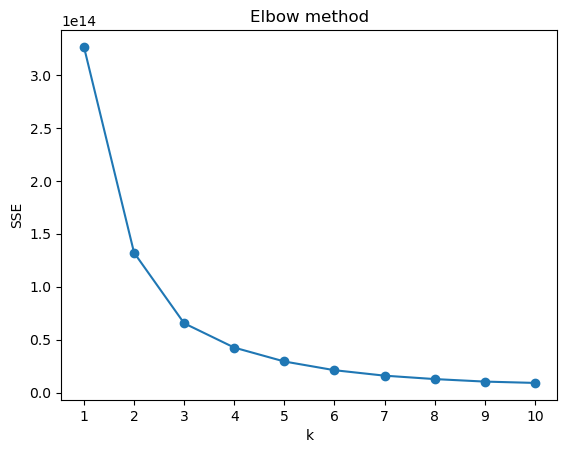

In [62]:
# Tìm số cụm thích hợp bằng Elbow
sse={}
for k in range(1,11):
    kmeans=KMeans(n_clusters=k, random_state=20)
    kmeans.fit(data_final[['overall_score', 'CLV']])
    sse[k]=kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), 'o-')
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(range(1,11))
plt.show()

In [70]:
# Phân cụm cho RFM và CLV
model=KMeans(n_clusters=4, random_state=2) # Lựa chọn k=4
data_final['CLV_segment']=model.fit_predict(data_final[['overall_score', 'CLV']])
data_final.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,overall_score,CLV,CLV_segment
0,50049,9.110434,2.302585,93.834962,3,4,2,3.3,828.705892,0
1,54881,10.723805,2.397895,102.908221,3,4,2,3.3,1264.489791,0
2,57200,8.717798,1.609438,71.400293,3,4,2,3.3,2447.040864,0
3,57734,8.831761,1.945910,109.512568,3,4,2,3.3,1009.937053,0
4,58279,8.660254,1.945910,81.222103,3,4,2,3.3,573.654783,0


''

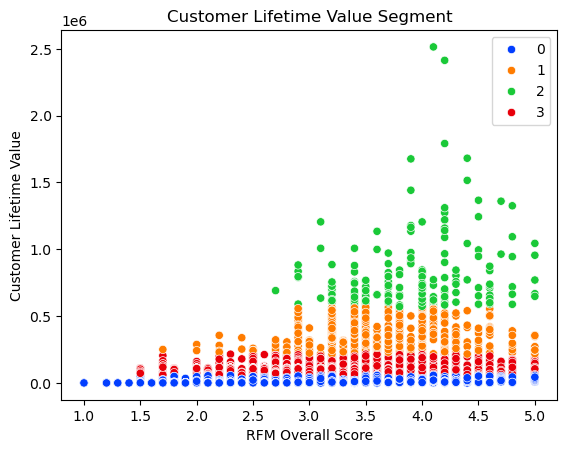

In [89]:
# Visualize kết quả
sns.scatterplot(data=data_final, x='overall_score', y='CLV', hue='CLV_segment', palette='bright')

plt.xlabel('RFM Overall Score')
plt.ylabel('Customer Lifetime Value')
plt.title('Customer Lifetime Value Segment')
plt.legend()
;

In [90]:
# Sắp xếp lại thứ tự các cụm
data_final=order_cluster('CLV_segment', 'CLV', data_final, True)

### 5. Xây dựng mô hình dự đoán phân khúc khách hàng

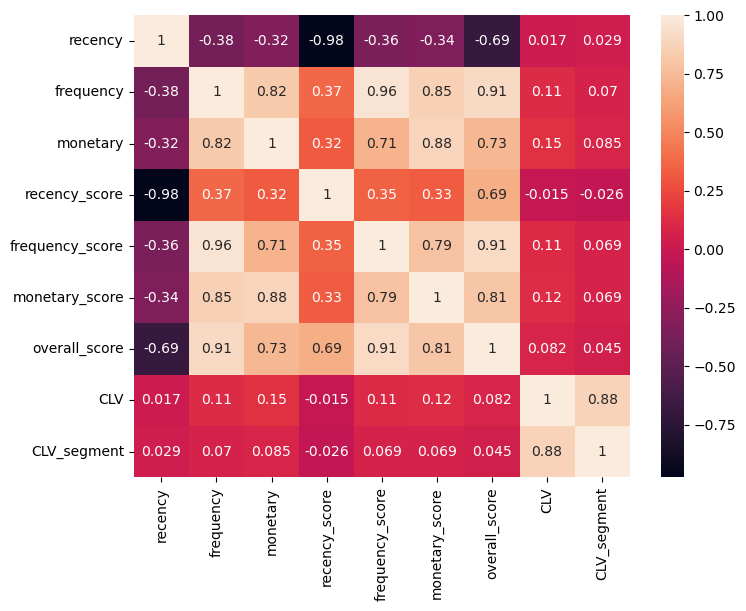

In [96]:
# Phân tích tương quan
plt.figure(figsize=(8,6))
corr=data_final.drop(columns='user_id').corr()
sns.heatmap(corr, annot=True);

In [110]:
# Thống kê phân khúc khách hàng
data_final['CLV_segment'].value_counts()

CLV_segment
0    332859
1      4798
2      1037
3       189
Name: count, dtype: int64

Phần lớn khách hàng thuộc lớp 0 và các lớp khác chiếm số lượng rất ít. từ đó cho thấy dữ liệu bị mất cân bằng

In [127]:
# Chia train test
from sklearn.model_selection import train_test_split

x=data_final.drop(columns=['user_id', 'CLV_segment'])
y=data_final['CLV_segment']

x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.25, random_state=1)

In [128]:
# Resampling data
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_train_rs, y_train_rs=smote.fit_resample(x_train, y_train)

In [139]:
# Train model với data không resample
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
lgbm=LGBMClassifier(random_state=1, verbosity=-1)

lgbm.fit(x_train, y_train)

y_pred=lgbm.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83240
           1       0.84      0.90      0.86      1200
           2       0.51      0.24      0.33       230
           3       0.00      0.00      0.00        51

    accuracy                           0.99     84721
   macro avg       0.59      0.53      0.55     84721
weighted avg       0.99      0.99      0.99     84721

[[83103    65    32    40]
 [  103  1074    21     2]
 [   56   118    56     0]
 [   24    27     0     0]]


Với data imbalanced, kết quả cho thấy mô hình không dự đoán đúng được bất cứ giá trị nào của lớp 3 (phân khúc cao nhất của khách hàng), trong khi lớp 2 có chỉ số f1 và recall rất thấp, chỉ có  lớp 0 và lớp 1 có kết quả tốt.

In [140]:
# Thử với data đã resample
lgbm.fit(x_train_rs, y_train_rs)

y_pred_rs=lgbm.predict(x_test)

print(classification_report(y_test, y_pred_rs))
print(confusion_matrix(y_test, y_pred_rs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83240
           1       0.99      0.99      0.99      1200
           2       0.99      1.00      0.99       230
           3       1.00      0.98      0.99        51

    accuracy                           1.00     84721
   macro avg       1.00      0.99      0.99     84721
weighted avg       1.00      1.00      1.00     84721

[[83234     6     0     0]
 [    4  1194     2     0]
 [    0     0   230     0]
 [    0     0     1    50]]


Với data sau khi đã upsampling, kết quả cho ra rất tốt